# Ripple waveform vs bilby waveform

* simulating frequency domain waveform using bilby and ripple

In [4]:
import jax.numpy as jnp
import numpy as np
import bilby

#from ripple.waveforms import IMRPhenomD
from ripple import ms_to_Mc_eta
from jax import vmap
from jax import jit
from gwsnr import noise_weighted_inner_product
from gwsnr import findchirp_chirptime

## Bilby waveform

In [111]:
size = 2
parameters = {
    "mass_1": np.array([20,30]),
    "mass_2": np.array([19,30]),
    "luminosity_distance": 440*np.ones(size),
    "theta_jn": 0.0*np.ones(size),
    "psi": 0.659*np.ones(size),
    "phase": 0.0*np.ones(size),
    "geocent_time": 0.*np.ones(size),
    "ra": 1.375*np.ones(size),
    "dec": -1.2108*np.ones(size),
    "a_1": 0.5*np.ones(size),
    "a_2": -0.5*np.ones(size),
    "tilt_1": 0.0*np.ones(size),
    "tilt_2": 0.0*np.ones(size),
    "phi_12": 0.0*np.ones(size),
    "phi_jl": 0.0*np.ones(size),
}

waveform_type = 'IMRPhenomD'
fref = 20.0
fmin = 20.0 
sampling_frequency = 2048.0
fmax = sampling_frequency / 2.0
fref = 20.0
# IMPORTANT: time duration calculation for each of the mass combination
safety = 1.2
mass_1 = parameters['mass_1']
mass_2 = parameters['mass_2']
approx_duration = safety * findchirp_chirptime(mass_1, mass_2, fmin)
duration = np.ceil(approx_duration + 2.0)


In [112]:
waveform_arguments = dict(
    waveform_approximant=waveform_type,
    reference_frequency=fref,
    minimum_frequency=fmin,
)

hp_bilby, hc_bilby, fs_bilby = [],[],[]
for i in range(size):

    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration[i],
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        waveform_arguments=waveform_arguments,
    )
    param = {}
    for key in parameters.keys():
        param[key] = parameters[key][i]

    polas = waveform_generator.frequency_domain_strain(param)
    hp_bilby.append(polas['plus'])
    hc_bilby.append(polas['cross'])
    fs_bilby.append(waveform_generator.frequency_array)

12:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


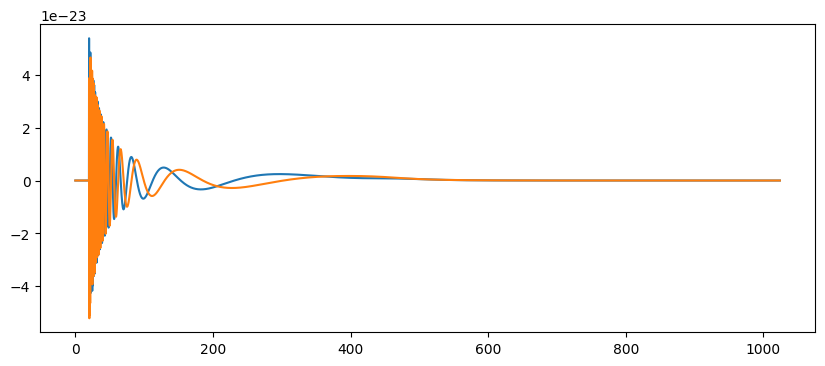

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4)) 
plt.plot(fs_bilby[0], np.real(hp_bilby[0]), label='hp')
plt.plot(fs_bilby[0], np.real(hc_bilby[0]), label='hc')
plt.show()

## Ripple waveform

In [187]:
from ripple.waveforms import IMRPhenomD

vmap_waveform = vmap(IMRPhenomD.gen_IMRPhenomD_hphc)

In [188]:
Mc, eta = ms_to_Mc_eta(jnp.array([ parameters['mass_1'][0], parameters['mass_2'][0] ]))
chi1 = parameters['a_1'][0]
chi2 = parameters['a_2'][0]
dist_mpc = parameters['luminosity_distance'][0]
tc = parameters['geocent_time'][0]
phic = parameters['phase'][0]
inclination = parameters['theta_jn'][0]
theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination])
f_l = fmin
f_u = fmax
del_f = 1/duration[0]


# m1_msun = 20.0 # In solar masses
# m2_msun = 19.0
# chi1 = 0.5 # Dimensionless spin
# chi2 = -0.5
# tc = 0.0 # Time of coalescence in seconds
# phic = 0.0 # Time of coalescence
# dist_mpc = 440 # Distance to source in Mpc
# inclination = 0.0 # Inclination Angle
# Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
# theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination])
# f_l = 24
# f_u = 512
# del_f = 0.01

fs = jnp.arange(0.0, f_u+del_f, del_f)
f_ref = f_l

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta_ripple, f_ref)

In [169]:
duration[0]

5.0

In [166]:
theta_ripple

Array([ 1.6969042e+01,  2.4983564e-01,  5.0000000e-01, -5.0000000e-01,
        4.4000000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],      dtype=float32)

In [168]:
hp_ripple, hp_bilby[0]

(Array([           nan          +nanj,  8.7957378e-21-8.5351719e-21j,
         2.9528823e-21-4.5845944e-21j, ..., -6.0834909e-29+5.9884474e-29j,
        -6.0693299e-29+5.9694036e-29j, -6.0552002e-29+5.9504200e-29j],      dtype=complex64),
 array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
        -6.08376608e-29+5.98821416e-29j, -6.06954224e-29+5.96922938e-29j,
         0.00000000e+00+0.00000000e+00j]))

In [161]:
hc_ripple

Array([           nan          +nanj, -8.5351719e-21-8.7957378e-21j,
       -4.5845944e-21-2.9528823e-21j, ...,  5.9884474e-29+6.0834909e-29j,
        5.9694036e-29+6.0693299e-29j,  5.9504200e-29+6.0552002e-29j],      dtype=complex64)

In [134]:
fs.shape, hp_ripple.shape, fs_bilby[0].shape, hp_bilby[0].shape

((5121,), (5121,), (5121,), (5121,))

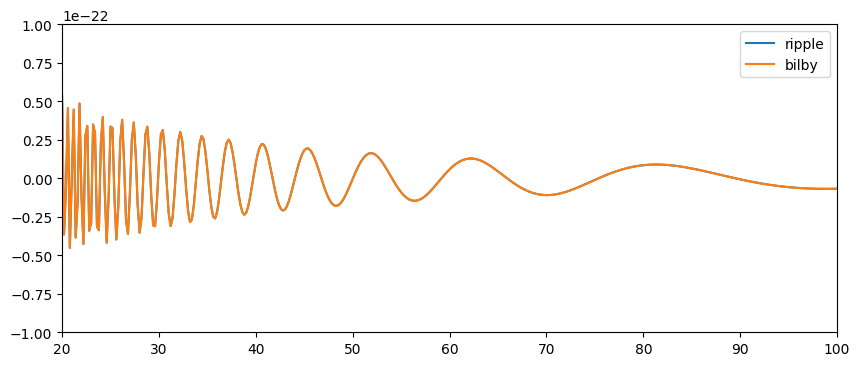

In [146]:
plt.figure(figsize=(10, 4))
plt.plot(fs, np.real(hp_ripple), label='ripple')
plt.plot(fs_bilby[0], np.real(hp_bilby[0]), label='bilby')
plt.xlim(20, 100)
plt.ylim(-1e-22, 1e-22)
plt.legend()
plt.show()

In [179]:
psd = bilby.gw.detector.PowerSpectralDensity(asd_file='aLIGO_O4_high_asd.txt')
psd = psd.get_power_spectral_density_array(fs)

In [190]:
# data conditioning
idx = np.abs(fs - 20.0).argmin()
hp_ripple, hc_ripple = np.array(hp_ripple), np.array(hc_ripple)
hp_ripple[0:idx] = 0.0 + 0.0j
hc_ripple[0:idx] = 0.0 + 0.0j

noise_weighted_inner_product(
                    hp_ripple,
                    hp_ripple,
                    psd,
                    5.0,
                )

(534.7578433302818+0j)

In [196]:
hp_ripple

array([ 0.000000e+00+0.0000000e+00j,  0.000000e+00+0.0000000e+00j,
        0.000000e+00+0.0000000e+00j, ..., -6.083491e-29+5.9884474e-29j,
       -6.069330e-29+5.9694036e-29j, -6.055200e-29+5.9504200e-29j],
      dtype=complex64)

In [194]:
hp_bilby[0]

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, ...,
       -6.08376608e-29+5.98821416e-29j, -6.06954224e-29+5.96922938e-29j,
        0.00000000e+00+0.00000000e+00j])

In [193]:
noise_weighted_inner_product(
                    hp_bilby[0],
                    hp_bilby[0],
                    psd,
                    5.0,
                )

(3528.2362001618058+0j)

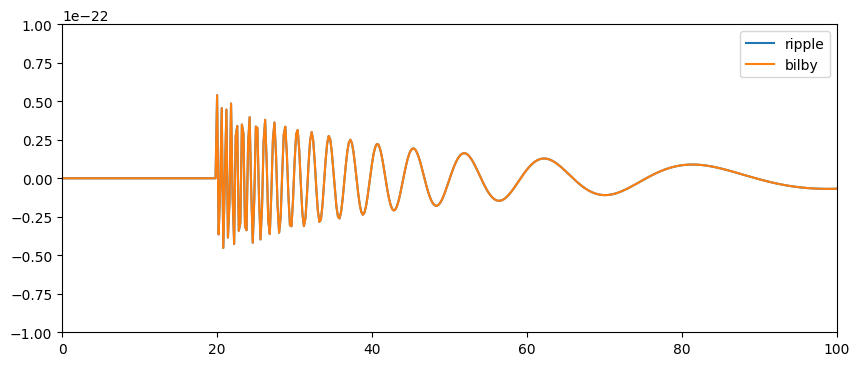

In [202]:
plt.figure(figsize=(10, 4))
plt.plot(fs, np.real(hp_ripple), label='ripple')
plt.plot(fs_bilby[0], np.real(hp_bilby[0]), label='bilby')
plt.xlim(0, 100)
plt.ylim(-1e-22, 1e-22)
plt.legend()
plt.show()

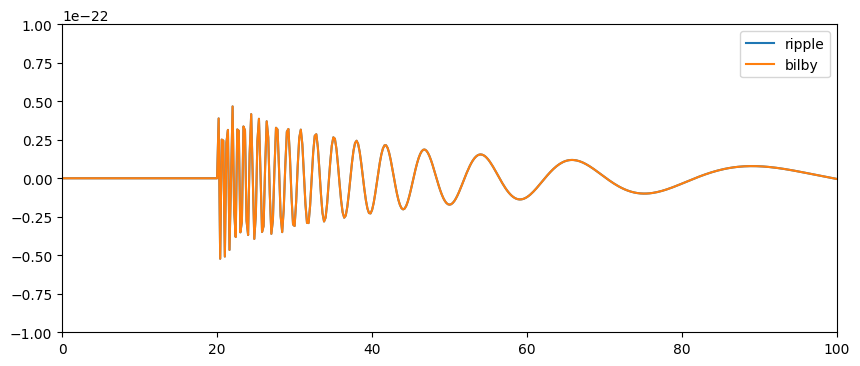

In [199]:
plt.figure(figsize=(10, 4))
plt.plot(fs, np.imag(hp_ripple), label='ripple')
plt.plot(fs_bilby[0], np.imag(hp_bilby[0]), label='bilby')
plt.xlim(0, 100)
plt.ylim(-1e-22, 1e-22)
plt.legend()
plt.show()

In [265]:
hp_ripple[-1] = 0.0 + 0.0j
signal1 = hp_ripple[idx:idx+2]
signal2 = hp_ripple[idx:idx+2]
nwip_arr_ripple = np.conj(signal1) * signal2 / psd[idx:idx+2]

signal1 = hp_bilby[0][idx:idx+2]
signal2 = hp_bilby[0][idx:idx+2]
nwip_arr_bilby = np.conj(signal1) * signal2 / psd[idx:idx+2]

In [277]:
np.conj(hp_ripple[idx:idx+2]), hp_ripple[idx:idx+2]

(array([ 5.394111e-23-0.0000000e+00j, -3.647436e-23-3.8855132e-23j],
       dtype=complex64),
 array([ 5.394111e-23+0.0000000e+00j, -3.647436e-23+3.8855132e-23j],
       dtype=complex64))

In [284]:
np.conj(np.array([5.394111e-23-0.0000000e+00j], dtype=np.complex128))* np.array([5.394111e-23-0.0000000e+00j], dtype=np.complex128)

array([2.90964335e-45+0.j])

In [279]:
np.conj(5.394111e-23-0.0000000e+00j)* (5.394111e-23-0.0000000e+00j)

(2.9096433480321004e-45+0j)

In [278]:
np.conj(hp_ripple[idx:idx+2]) * hp_ripple[idx:idx+2]

array([3.e-45+0.j, 3.e-45+0.j], dtype=complex64)

In [273]:
np.conj(hp_bilby[0][idx:idx+2]), hp_bilby[0][idx:idx+2]

(array([ 5.39411148e-23-0.00000000e+00j, -3.64741879e-23-3.88553131e-23j]),
 array([ 5.39411148e-23+0.00000000e+00j, -3.64741879e-23+3.88553131e-23j]))

In [275]:
np.conj(hp_bilby[0][idx:idx+2]) * hp_bilby[0][idx:idx+2]

array([2.90964387e-45+0.j, 2.84010174e-45+0.j])

In [244]:
np.sum(nwip_arr_ripple), np.sum(nwip_arr_bilby)

((1.4644822424735717+0j), (1.5204190552078858+0j))

In [220]:
hp_ripple[idx-2:idx+2], hp_bilby[0][idx-2:idx+2]

(array([ 0.000000e+00+0.0000000e+00j,  0.000000e+00+0.0000000e+00j,
         5.394111e-23+0.0000000e+00j, -3.647436e-23+3.8855132e-23j],
       dtype=complex64),
 array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         5.39411148e-23+0.00000000e+00j, -3.64741879e-23+3.88553131e-23j]))

In [238]:
np.sum(hp_ripple), np.sum(hp_bilby[0])

((1.5416762e-21+7.367319e-22j),
 (1.5416216987783775e-21+7.368693957828749e-22j))

In [147]:
# setup input arguments
parameters['Mchirp'], parameters['eta'] = ms_to_Mc_eta(jnp.array([ parameters['mass_1'], parameters['mass_2'] ]))

arg_list = ['Mchirp', 'eta', 'a_1', 'a_2', 'luminosity_distance', 'geocent_time', 'phase', 'theta_jn']

theta_ripple = []
for key in arg_list:
    if key not in parameters.keys():
        raise ValueError(f"Missing key {key} in parameters")
    else:
        theta_ripple.append(parameters[key])
theta_ripple = jnp.array(theta_ripple).T

del_f = 1.0 / duration
fs = []
# fsize calculation should not have min() function as del_f is a scalar

fsize_max = int((fmax - 0.0) / min(del_f)) + 2  # +1 to include upper limit
#print(f"fs max size: {fsize_max}")
fsize_arr = []
for df  in del_f: # If you have multiple del_f values, iterate accordingly
    flist = np.arange(0.0, fmax + df, df)
    fsize_arr.append(len(flist))

    #print(len(flist))
    if len(flist) < fsize_max:
        # Add NaN values to make the array size equal to fsize_max
        flist = np.concatenate([flist, np.full(fsize_max - len(flist), np.nan)])
        #print(len(flist))
    fs.append(flist)

fs = jnp.array(fs)

# compute the waveform h+ and hx
f_ref = fref * jnp.ones((size,1))

In [148]:
hp, hc = vmap_waveform(fs, theta_ripple, f_ref)

In [149]:
hp_ripple, hc_ripple, fs_ripple = [], [], []
for i in range(size):
    hp_ripple.append(np.array(hp[i][:fsize_arr[i]]))
    hc_ripple.append(np.array(hc[i][:fsize_arr[i]]))
    fs_ripple.append(np.array(fs[i][:fsize_arr[i]]))
# hp_ripple = np.array(hp_ripple, dtype=object)
# hc_ripple = np.array(hc_ripple, dtype=object)

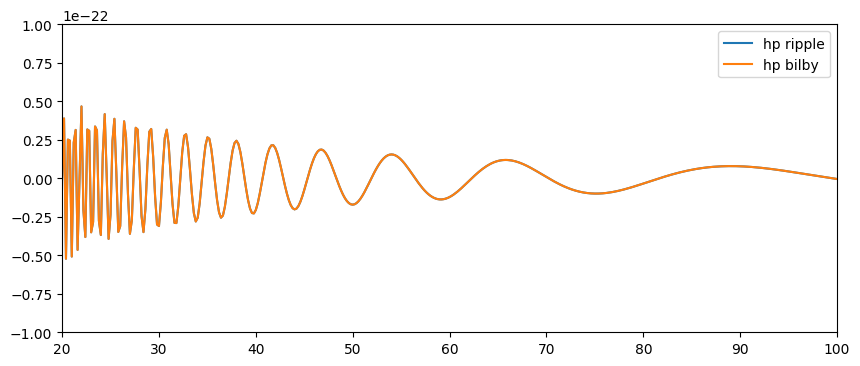

In [154]:
plt.figure(figsize=(10, 4))
plt.plot(fs_ripple[0], np.imag(hp_ripple[0]), label='hp ripple')
plt.plot(fs_bilby[0], np.imag(hp_bilby[0]), label='hp bilby')
#plt.plot(fs_ripple[0], np.real(hc_ripple[0]), label='hc')
plt.xlim(20, 100)
plt.ylim(-1e-22, 1e-22)
plt.legend()
plt.show()

* get hp, hc from the ripple class
* get hc, hp from gwsnr mp and save it to a file